In [1]:
from keras.models  import load_model
import keras.backend as K

import cPickle
import sys
sys.path.insert(0, '../../preprocess')
import vectorizer

from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np

from support import norm

aspects = ['population', 'intervention', 'outcome']

Using TensorFlow backend.


In [2]:
vec = cPickle.load(open('../data/vectorizers/allfields_with_embedding_5000.p', 'rb'))

In [3]:
da = pd.read_csv('../data/files/decision_aids_filter.csv')
im_map = {'breast cancer': 'BCT', 
          'healthy women at risk of breast cancer': 'BCS', 
          'type II diabetes': 'D',
          'menopausal women': 'MW',
          'pregnant women, previous C section': 'PWC',
          'pregnant women': 'PW',
          'healthy people, at risk colon cancer': 'CCS',
          'prostate cancer': 'PCT',
          'healthy men, contemplating risk of prostate cancer': 'PCS',
          'AF': 'AF',
          'healthy women at genetic risk of breast cancer': 'BCG'}

In [4]:
davec = cPickle.load(open('../data/vectorizers/decision_aids_vec_5000.p'))

In [39]:
file_model = '../store/weights/single_setup/TueOct2420:19:082017/loss.h5'
contrastive_loss = lambda a,b : K.mean(b)
#result_folder = '../store/results/single_message_WedOc/'
model = load_model(file_model, custom_objects={'norm' : norm, '<lambda>' : contrastive_loss})

In [40]:
model_aspect = {}
for aspect in aspects :
    model_aspect[aspect] = K.function(model.get_layer('pool_'+aspect[0].upper()).inputs + [K.learning_phase()], 
                          [model.get_layer('pool_'+aspect[0].upper()).get_output_at(0)])

In [41]:
pool_da = {}
norm_pool_da = {}

for aspect in aspects :
    pool_da[aspect] = model_aspect[aspect]([davec.X, 0])[0]
    norm_pool_da[aspect] = normalize(pool_da[aspect], 'l2')

In [42]:
irange = vec.index['abstract']
X_abs = vec.X[irange[0]:irange[1]]
pool_cdsr = {}
norm_pool_cdsr = {}

for aspect in aspects :
    pool_cdsr[aspect] = []
    for i in range(int(np.floor(len(X_abs)/1000))) :
        pool_cdsr[aspect].append(model_aspect[aspect]([X_abs[i*1000:(i+1)*1000,:], 0])[0])
    pool_cdsr[aspect] = np.concatenate(pool_cdsr[aspect])
    norm_pool_cdsr[aspect] = normalize(pool_cdsr[aspect], 'l2')

In [43]:
from sklearn.decomposition import PCA
pca_models = {}
for aspect in aspects :
    pca = PCA()
    pca.fit(np.concatenate([norm_pool_cdsr[aspect], norm_pool_da[aspect]], axis=0))
    pca_models[aspect] = pca
    
pcas = {}
for aspect in aspects :
    pcas[aspect] = pca_models[aspect].transform(norm_pool_da[aspect])

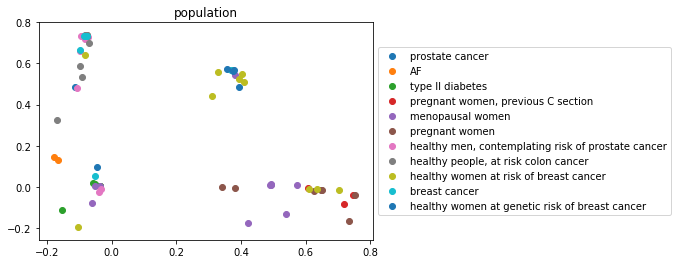

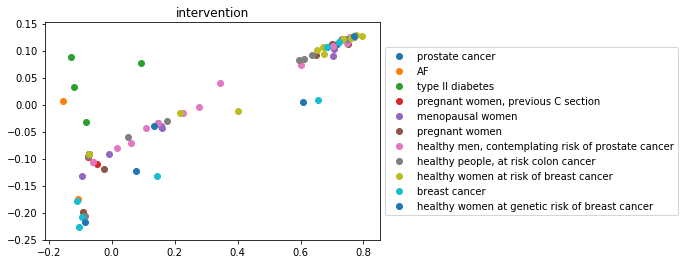

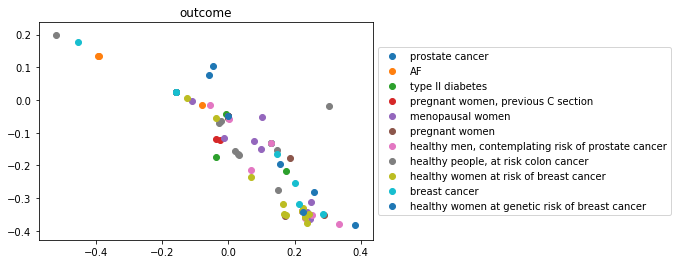

In [44]:
import matplotlib.pyplot as plt
for aspect in aspects :
    for key in im_map.keys() :
        idxs = da[da['IM_population'] == key].index
        plt.scatter(pcas[aspect][idxs, 0], pcas[aspect][idxs, 1], label=key)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(aspect)
    plt.show()

In [45]:
nb_studies = len(da)
H = np.zeros((nb_studies, nb_studies))
for i in range(nb_studies) :
    H[i, da[da['IM_population'] == da['IM_population'][i]].index] = 1
np.fill_diagonal(H, 0)

scores = {}
for aspect in aspects :
    scores[aspect] = np.dot(norm_pool_da[aspect], norm_pool_da[aspect].T)
    np.fill_diagonal(scores[aspect], -1000)

In [46]:
from sklearn.metrics import roc_auc_score
series = {}
for aspect in aspects :
    aucs = [0] * nb_studies
    for i in range(nb_studies) :
        aucs[i] = roc_auc_score(H[i], scores[aspect][i])
    rocs = {}
    for key in im_map :
        idxs = da[da['IM_population'] == key].index
        rocs[key] = np.mean(np.array(aucs)[idxs])
    rocs['mean'] = np.mean(aucs)
    series[aspect] = pd.Series(rocs, name=aspect)
pd.DataFrame(series.values())

,AF,breast cancer,"healthy men, contemplating risk of prostate cancer","healthy people, at risk colon cancer",healthy women at genetic risk of breast cancer,healthy women at risk of breast cancer,mean,menopausal women,pregnant women,"pregnant women, previous C section",prostate cancer,type II diabetes
outcome,0.469246,0.651675,0.641337,0.748462,0.498193,0.699528,0.610047,0.539601,0.515726,0.638235,0.510542,0.468675
intervention,0.492063,0.654468,0.504505,0.432051,0.555723,0.746163,0.554173,0.613177,0.534098,0.472549,0.459639,0.579518
population,0.509425,0.653586,0.774415,0.821795,0.770783,0.684357,0.732728,0.654487,0.917402,0.925490,0.629819,0.602410


In [ ]:
get_ipython().system('cp "Decision Aids Single.ipynb" '+result_folder)